In [89]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(42)
random.seed(42)

In [90]:
# load ~32000 names from a file, one in each line
with open("names.txt", "r") as infile:
    words = infile.read().splitlines() # ignores \n
chars = sorted(set("".join(words) + "."))
vocab_size = len(chars)
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for c, i in ctoi.items()}

In [91]:
# building the dataset (with contexts)

# training split -> ~80% -> optimize parameters of the model using gradient descent
# dev/validation split -> ~10% -> hyperparameter tuning
# test split -> ~10% -> evaluate model's final performance

# updated so that we can also create dev/test splits

context_len = 8 # context length - how many chars to take into account to predict the next one?

def build_dataset(words):
    X, Y = [], [] # X - input to the neural net, Y - expected labels for each example inside X
    
    for w in words:
        # print(w)
        context = [0] * context_len # ...
        for c in w + ".":
            idx = ctoi[c]
            X.append(context)
            Y.append(idx)
            # print("".join(itoc[i] for i in context), "--->", itoc[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [92]:
Xtr[[14, 15, 16]]

tensor([[ 0,  4,  9, 15, 14,  4, 18,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 24]])

In [105]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None # 1 dim but works because of broadcasting, zeros!

    def __call__(self, x): # x are the incoming activations
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -------------------------------------------------------------------------------------------------------------

class BatchNorm1d: # after adding dim, it now differs a bit from the PyTorch version (NLC vs NCL)
    def __init__(self, dim, eps=1e-5, momentum=0.1): # dim -> number of hidden neurons
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # bngain
        self.beta = torch.zeros(dim) # bnbias
        # buffers (trained with a running "momentum" update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
        
# -------------------------------------------------------------------------------------------------------------

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# -------------------------------------------------------------------------------------------------------------

class Embedding:
    def __init__(self, num_embeddings, embedding_dim): # size of the dictionary of embeddings, size of each embedding vector
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, X): # X is a tensor of character embeddings
        self.out = self.weight[X]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -------------------------------------------------------------------------------------------------------------

class Flatten: # it's like a Tanh layer, just processes the information and doesn't store anything, no parameters and no __init__
    def __call__(self, X):
        self.out = X.view(X.shape[0], -1)
        return self.out

    def parameters(self):
        return []

# -------------------------------------------------------------------------------------------------------------

class FlattenConsecutive: # it's like a Tanh layer, just processes the information and doesn't store anything, no parameters and no __init__
    def __init__(self, n):
        self.n = n
    
    def __call__(self, X):
        B, C, E = X.shape
        X = X.view(B, C // self.n, E * self.n)
        if X.shape[1] == 1:
            X = X.squeeze(1)
        self.out = X
        return self.out

    def parameters(self):
        return []

# -------------------------------------------------------------------------------------------------------------

class Sequential: # container so that we don't have to do a for loop over layers explicitly
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, X): # X is the initial input, Xb in our case
        for layer in self.layers:
            X = layer(X)
        self.out = X
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [127]:
n_embd = 20 # character embedding vector dimension
n_hidden = 128 # number of neurons in a hidden layer

# original
# model = Sequential([
#     Embedding(vocab_size, n_embd), # eq.to C = torch.randn((vocab_size, n_embd)) -> just sets that up, then gets called in main loop
#     Flatten(), # does nothing now, no _init__, just so out model knows that Flatten() should be called later
#     Linear(n_embd * context_len, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size)
# ])

# conv
model = Sequential([
    Embedding(vocab_size, n_embd), # eq.to C = torch.randn((vocab_size, n_embd)) -> just sets that up, then gets called in main loop
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # to lower the initial loss (?)
    # apply gain
    for layer in model.layers[:-1]: # why doesn't he use that anymore?? - CHECK!!!
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

75447


In [128]:
epochs = 200_000
minibatch_size = 64
loss_i = []

for i in range(epochs):
    # create a minibatch
    idx = torch.randint(0, Xtr.shape[0], (minibatch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    # for layer in layers: WHY NO MORE OF THAT???
    #     layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < epochs / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i}/{epochs}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

0/200000: 3.2996
10000/200000: 2.3936
20000/200000: 2.0958
30000/200000: 1.7241
40000/200000: 1.7984
50000/200000: 1.7757
60000/200000: 1.9949
70000/200000: 1.6387
80000/200000: 1.8328
90000/200000: 1.6618
100000/200000: 1.7712
110000/200000: 1.8470
120000/200000: 1.6496
130000/200000: 1.6191
140000/200000: 1.7774
150000/200000: 1.6781
160000/200000: 1.9735
170000/200000: 1.8830
180000/200000: 1.7180
190000/200000: 1.9283


In [129]:
for layer in model.layers:
    print(layer.__class__.__name__ , ":", tuple(layer.out.shape)) 

Embedding : (64, 8, 20)
FlattenConsecutive : (64, 4, 40)
Linear : (64, 4, 128)
BatchNorm1d : (64, 4, 128)
Tanh : (64, 4, 128)
FlattenConsecutive : (64, 2, 256)
Linear : (64, 2, 128)
BatchNorm1d : (64, 2, 128)
Tanh : (64, 2, 128)
FlattenConsecutive : (64, 256)
Linear : (64, 128)
BatchNorm1d : (64, 128)
Tanh : (64, 128)
Linear : (64, 27)


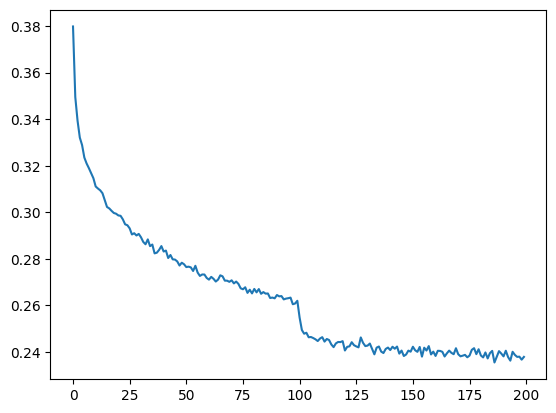

In [130]:
plt.plot(torch.tensor(loss_i).view(-1, 1000).mean(1))

In [131]:
for layer in model.layers:
    layer.training = False

In [132]:
@torch.no_grad()
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xdev, Ydev), "test": (Xtest, Ytest)}[split] #!!!
    logits = model(X)
    loss = F.cross_entropy(logits, Y) # more efficient, prevents inf and nan for big positive logits
    print(split, loss.item())

In [133]:
# find out the loss for a whole (TR!) data set, not just a minibatch
split_loss("train")

# tr loss ~= dev loss -> not overfitting (actually maybe underfitting!)
# <=> nn not able to memorize the values
# might mean that the network is too small (not enough parameters)

# find out the loss for a whole (DEV!) data set
split_loss("dev")

train 1.7075684070587158
dev 2.035825252532959


In [137]:
# batch-32, context-8, emb-24, hidden-128 (no conv, 28963 params):
# train 1.90327787399292
# dev 2.0320699214935303
# train 1.8411145210266113
# dev 2.0521371364593506

# same but with conv (76579 params):
# train 1.7897275686264038
# dev 1.9917486906051636
# train 1.7924081087112427
# dev 1.9847874641418457

# conv batch-64, context-8, emb-20, hidden-128 (75447 params):
# train 1.7075684070587158
# dev 2.035825252532959
# LOL SO BAD

In [136]:
# SAMPLING
for _ in range(20):
    name = []
    context = [0] * context_len # initialize with all ...
    while True: # create one name
        logits = model(torch.tensor([context])) # like C[X] but this time only 1 context, [context] bcos it creates an additional batch dim (just 1, so 1x...)
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [idx]
        name.append(idx)
        if idx == 0:
            break
    print("".join(itoc[i] for i in name))

ailiyah.
shere.
amyri.
danylah.
daysie.
sanaiya.
sharaiah.
emrin.
adalla.
samar.
kizire.
khlieann.
lacery.
tryson.
arohi.
kamaria.
delmon.
yousef.
arielys.
zency.
